In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
df = pd.read_csv("alltracks.csv", index_col=0)

In [7]:
index_to_delete = df[df['tags'] == '[]'].index
df.drop(index_to_delete, inplace=True)

In [8]:
df

,track_name,artist,album_name,date_listened,uts,url,tags
0,Untouched,SilenCee,Untouched,"07 Dec 2022, 09:30",1670405412,https://www.last.fm/music/SilenCee/_/Untouched,electronic
1,maria,Malte,maria,"07 Dec 2022, 09:18",1670404731,https://www.last.fm/music/Malte/_/maria,german
2,let me go,Malte,let me go,"07 Dec 2022, 09:16",1670404596,https://www.last.fm/music/Malte/_/let+me+go,german
3,So What,mqx,So What,"07 Dec 2022, 09:14",1670404473,https://www.last.fm/music/mqx/_/So+What,hardstyle
4,maria,Malte,maria,"07 Dec 2022, 09:11",1670404288,https://www.last.fm/music/Malte/_/maria,german
...,...,...,...,...,...,...,...
18553,Slippery People - Live,Talking Heads,Stop Making Sense (Live),"07 Aug 2024, 21:15",1723065315,https://www.last.fm/music/Talking+Heads/_/Slip...,new wave
18554,Found a Job,Talking Heads,Stop Making Sense (Live),"07 Aug 2024, 21:12",1723065120,https://www.last.fm/music/Talking+Heads/_/Foun...,new wave
18555,Thank You for Sending Me an Angel - Live,Talking Heads,Stop Making Sense (Live),"07 Aug 2024, 21:09",1723064990,https://www.last.fm/music/Talking+Heads/_/Than...,new wave
18556,Heaven - Live,Talking Heads,Stop Making Sense (Live),"07 Aug 2024, 21:06",1723064770,https://www.last.fm/music/Talking+Heads/_/Heav...,new wave


Check for null values and inspect the data

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18229 entries, 0 to 18557
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   track_name     18229 non-null  object
 1   artist         18229 non-null  object
 2   album_name     18229 non-null  object
 3   date_listened  18229 non-null  object
 4   uts            18229 non-null  int64 
 5   url            18229 non-null  object
 6   tags           18229 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.6+ MB


In [10]:
df.isnull().sum()

,0
track_name,0
artist,0
album_name,0
date_listened,0
uts,0
url,0
tags,0


In [11]:
df['artist'].value_counts()

,count
artist,
Radiohead,2498
The Strokes,427
JPEGMAFIA,415
The Smile,410
Talking Heads,347
...,...
elricfd,1
Kara Jackson,1
Jane Remover,1


In [12]:
artist_counts = df.groupby('artist').agg({
    'track_name': 'count',
    'tags': 'first'
}).reset_index()
artist_counts.rename(columns={'track_name': 'count'}, inplace=True)

artist_counts

,artist,count,tags
0,!!!,2,seen live
1,100 gecs,7,hyperpop
2,1999 WRITE THE FUTURE,1,rap
3,21 Savage,3,trap
4,2562,3,dubstep
...,...,...,...
1259,ДЕТИ RAVE,2,Rave
1260,万能青年旅店,1,rock
1261,久石譲,48,Soundtrack
1262,光良,1,chinese


In [13]:
artist_counts = artist_counts.sort_values(by='count', ascending=False).reset_index(drop=True)
artist_counts

top_10_artists = artist_counts[artist_counts.index < 10]
top_10_artists

,artist,count,tags
0,Radiohead,2498,alternative
1,The Strokes,427,indie rock
2,JPEGMAFIA,415,Hip-Hop
3,The Smile,410,post-punk
4,Talking Heads,347,new wave
5,Frank Ocean,304,rnb
6,Malte,299,german
7,King Gizzard & The Lizard Wizard,277,Psychedelic Rock
8,Tame Impala,276,Psychedelic Rock
9,LCD Soundsystem,275,electronic


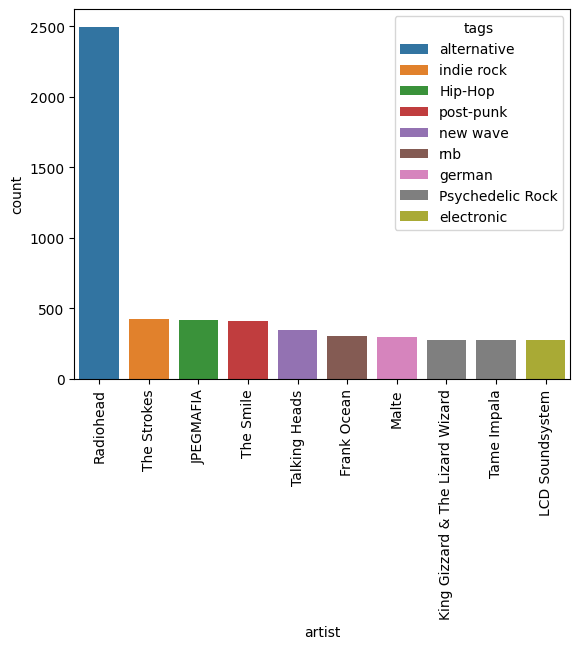

In [14]:
sns.barplot(top_10_artists, x='artist', y='count', hue='tags');
plt.xticks(rotation=90);

In [15]:
df['date_listened'] = pd.to_datetime(df['date_listened'])
df = df.sort_values(by='date_listened')


In [16]:
df

,track_name,artist,album_name,date_listened,uts,url,tags
370,You Want It Darker,Leonard Cohen,You Want It Darker,2022-11-30 14:34:00,1669818859,https://www.last.fm/music/Leonard+Cohen/_/You+...,singer-songwriter
369,You Want It Darker,Leonard Cohen,You Want It Darker,2022-11-30 16:02:00,1669824136,https://www.last.fm/music/Leonard+Cohen/_/You+...,singer-songwriter
368,All My Friends (feat. Tinashe & Chance the Rap...,Snakehips,All My Friends (feat. Tinashe & Chance The Rap...,2022-12-01 01:45:00,1669859126,https://www.last.fm/music/Snakehips/_/All+My+F...,electronic
367,Green Onions,Booker T. & The M.G.'s,Green Onions,2022-12-01 01:48:00,1669859298,https://www.last.fm/music/Booker+T.+&+The+M.G....,soul
366,715 - CR∑∑KS,Bon Iver,"22, a Million",2022-12-01 01:50:00,1669859425,https://www.last.fm/music/Bon+Iver/_/715+-+CR%...,folk
...,...,...,...,...,...,...,...
18377,Le Risque,King Gizzard & The Lizard Wizard,Flight b741,2024-08-12 05:06:00,1723439181,https://www.last.fm/music/King+Gizzard+&+The+L...,Psychedelic Rock
18376,Flight b741,King Gizzard & The Lizard Wizard,Flight b741,2024-08-12 05:08:00,1723439339,https://www.last.fm/music/King+Gizzard+&+The+L...,Psychedelic Rock
18375,Sad Pilot,King Gizzard & The Lizard Wizard,Flight b741,2024-08-12 05:12:00,1723439578,https://www.last.fm/music/King+Gizzard+&+The+L...,Psychedelic Rock
18374,Rats In The Sky,King Gizzard & The Lizard Wizard,Flight b741,2024-08-12 05:17:00,1723439829,https://www.last.fm/music/King+Gizzard+&+The+L...,Psychedelic Rock


In [17]:
df.set_index('date_listened', inplace=True)

In [18]:
df

,track_name,artist,album_name,uts,url,tags
date_listened,,,,,,
2022-11-30 14:34:00,You Want It Darker,Leonard Cohen,You Want It Darker,1669818859,https://www.last.fm/music/Leonard+Cohen/_/You+...,singer-songwriter
2022-11-30 16:02:00,You Want It Darker,Leonard Cohen,You Want It Darker,1669824136,https://www.last.fm/music/Leonard+Cohen/_/You+...,singer-songwriter
2022-12-01 01:45:00,All My Friends (feat. Tinashe & Chance the Rap...,Snakehips,All My Friends (feat. Tinashe & Chance The Rap...,1669859126,https://www.last.fm/music/Snakehips/_/All+My+F...,electronic
2022-12-01 01:48:00,Green Onions,Booker T. & The M.G.'s,Green Onions,1669859298,https://www.last.fm/music/Booker+T.+&+The+M.G....,soul
2022-12-01 01:50:00,715 - CR∑∑KS,Bon Iver,"22, a Million",1669859425,https://www.last.fm/music/Bon+Iver/_/715+-+CR%...,folk
...,...,...,...,...,...,...
2024-08-12 05:06:00,Le Risque,King Gizzard & The Lizard Wizard,Flight b741,1723439181,https://www.last.fm/music/King+Gizzard+&+The+L...,Psychedelic Rock
2024-08-12 05:08:00,Flight b741,King Gizzard & The Lizard Wizard,Flight b741,1723439339,https://www.last.fm/music/King+Gizzard+&+The+L...,Psychedelic Rock
2024-08-12 05:12:00,Sad Pilot,King Gizzard & The Lizard Wizard,Flight b741,1723439578,https://www.last.fm/music/King+Gizzard+&+The+L...,Psychedelic Rock


In [19]:
monthly_counts = df['track_name'].resample('M').count()
monthly_counts = monthly_counts.reset_index()

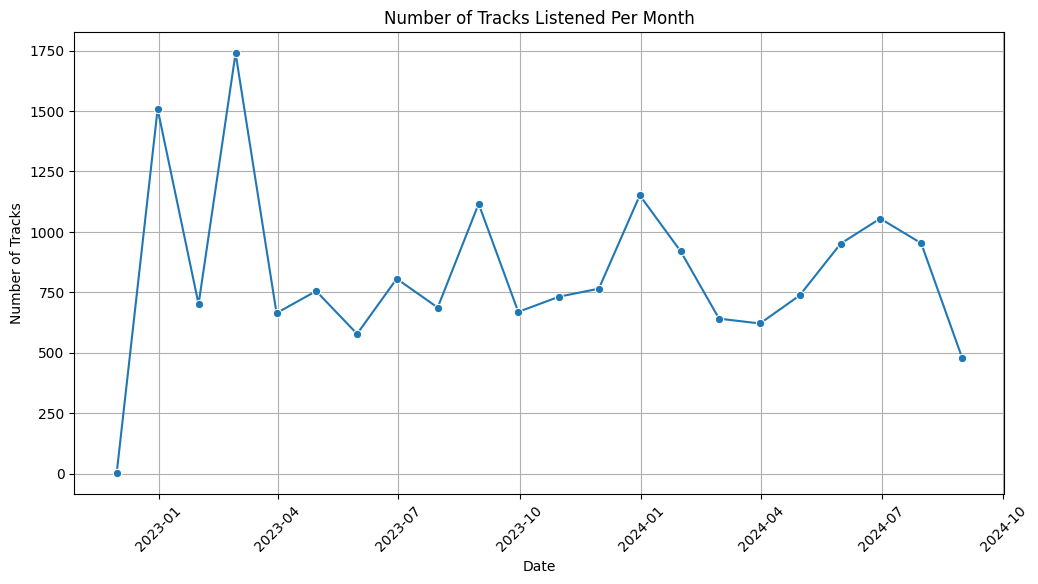

In [20]:
# Plot the data using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_counts, x='date_listened', y='track_name', marker='o')
plt.title('Number of Tracks Listened Per Month')
plt.xlabel('Date')
plt.ylabel('Number of Tracks')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [21]:
df = df.reset_index()

# RNN Model preprocessing

In [22]:
one_month = df[(df['date_listened'] > '2024-07-01') & (df['date_listened'] < '2024-07-31')]
one_month

,date_listened,track_name,artist,album_name,uts,url,tags
16797,2024-07-01 00:24:00,Wall of Eyes,The Smile,Wall of Eyes,1719793468,https://www.last.fm/music/The+Smile/_/Wall+of+...,post-punk
16798,2024-07-01 00:29:00,Teleharmonic,The Smile,Wall of Eyes,1719793778,https://www.last.fm/music/The+Smile/_/Teleharm...,post-punk
16799,2024-07-01 00:34:00,Read the Room,The Smile,Wall of Eyes,1719794093,https://www.last.fm/music/The+Smile/_/Read+the...,post-punk
16800,2024-07-01 01:30:00,Under Our Pillows,The Smile,Wall of Eyes,1719797414,https://www.last.fm/music/The+Smile/_/Under+Ou...,post-punk
16801,2024-07-01 05:41:00,Reel Around the Fountain - 2011 Remaster,The Smiths,The Smiths,1719812510,https://www.last.fm/music/The+Smiths/_/Reel+Ar...,indie
...,...,...,...,...,...,...,...
17680,2024-07-30 23:37:00,Play for Today,The Cure,Seventeen Seconds,1722382678,https://www.last.fm/music/The+Cure/_/Play+for+...,post-punk
17681,2024-07-30 23:41:00,Secrets,The Cure,Seventeen Seconds,1722382897,https://www.last.fm/music/The+Cure/_/Secrets,post-punk
17682,2024-07-30 23:44:00,In Your House,The Cure,Seventeen Seconds,1722383096,https://www.last.fm/music/The+Cure/_/In+Your+H...,post-punk
17683,2024-07-30 23:49:00,Three,The Cure,Seventeen Seconds,1722383341,https://www.last.fm/music/The+Cure/_/Three,post-punk


In [23]:
df['session_id'] = (df['date_listened'].diff() > pd.Timedelta(minutes=20)).cumsum()

In [24]:
df

,date_listened,track_name,artist,album_name,uts,url,tags,session_id
0,2022-11-30 14:34:00,You Want It Darker,Leonard Cohen,You Want It Darker,1669818859,https://www.last.fm/music/Leonard+Cohen/_/You+...,singer-songwriter,0
1,2022-11-30 16:02:00,You Want It Darker,Leonard Cohen,You Want It Darker,1669824136,https://www.last.fm/music/Leonard+Cohen/_/You+...,singer-songwriter,1
2,2022-12-01 01:45:00,All My Friends (feat. Tinashe & Chance the Rap...,Snakehips,All My Friends (feat. Tinashe & Chance The Rap...,1669859126,https://www.last.fm/music/Snakehips/_/All+My+F...,electronic,2
3,2022-12-01 01:48:00,Green Onions,Booker T. & The M.G.'s,Green Onions,1669859298,https://www.last.fm/music/Booker+T.+&+The+M.G....,soul,2
4,2022-12-01 01:50:00,715 - CR∑∑KS,Bon Iver,"22, a Million",1669859425,https://www.last.fm/music/Bon+Iver/_/715+-+CR%...,folk,2
...,...,...,...,...,...,...,...,...
18224,2024-08-12 05:06:00,Le Risque,King Gizzard & The Lizard Wizard,Flight b741,1723439181,https://www.last.fm/music/King+Gizzard+&+The+L...,Psychedelic Rock,2506
18225,2024-08-12 05:08:00,Flight b741,King Gizzard & The Lizard Wizard,Flight b741,1723439339,https://www.last.fm/music/King+Gizzard+&+The+L...,Psychedelic Rock,2506
18226,2024-08-12 05:12:00,Sad Pilot,King Gizzard & The Lizard Wizard,Flight b741,1723439578,https://www.last.fm/music/King+Gizzard+&+The+L...,Psychedelic Rock,2506
18227,2024-08-12 05:17:00,Rats In The Sky,King Gizzard & The Lizard Wizard,Flight b741,1723439829,https://www.last.fm/music/King+Gizzard+&+The+L...,Psychedelic Rock,2506


In [25]:
from sklearn.preprocessing import LabelEncoder
track_encoder = LabelEncoder()
artist_encoder = LabelEncoder()
genre_encoder = LabelEncoder()
df['song_id'] = track_encoder.fit_transform(df['track_name']) + 1 # avoid 0 as 0 is padding value
df['artist_id'] = artist_encoder.fit_transform(df['artist']) + 1
df['genre_id'] = genre_encoder.fit_transform(df['tags']) + 1


In [26]:
df

,date_listened,track_name,artist,album_name,uts,url,tags,session_id,song_id,artist_id,genre_id
0,2022-11-30 14:34:00,You Want It Darker,Leonard Cohen,You Want It Darker,1669818859,https://www.last.fm/music/Leonard+Cohen/_/You+...,singer-songwriter,0,5333,632,211
1,2022-11-30 16:02:00,You Want It Darker,Leonard Cohen,You Want It Darker,1669824136,https://www.last.fm/music/Leonard+Cohen/_/You+...,singer-songwriter,1,5333,632,211
2,2022-12-01 01:45:00,All My Friends (feat. Tinashe & Chance the Rap...,Snakehips,All My Friends (feat. Tinashe & Chance The Rap...,1669859126,https://www.last.fm/music/Snakehips/_/All+My+F...,electronic,2,302,943,103
3,2022-12-01 01:48:00,Green Onions,Booker T. & The M.G.'s,Green Onions,1669859298,https://www.last.fm/music/Booker+T.+&+The+M.G....,soul,2,1873,143,215
4,2022-12-01 01:50:00,715 - CR∑∑KS,Bon Iver,"22, a Million",1669859425,https://www.last.fm/music/Bon+Iver/_/715+-+CR%...,folk,2,148,142,115
...,...,...,...,...,...,...,...,...,...,...,...
18224,2024-08-12 05:06:00,Le Risque,King Gizzard & The Lizard Wizard,Flight b741,1723439181,https://www.last.fm/music/King+Gizzard+&+The+L...,Psychedelic Rock,2506,2663,595,37
18225,2024-08-12 05:08:00,Flight b741,King Gizzard & The Lizard Wizard,Flight b741,1723439339,https://www.last.fm/music/King+Gizzard+&+The+L...,Psychedelic Rock,2506,1584,595,37
18226,2024-08-12 05:12:00,Sad Pilot,King Gizzard & The Lizard Wizard,Flight b741,1723439578,https://www.last.fm/music/King+Gizzard+&+The+L...,Psychedelic Rock,2506,3931,595,37
18227,2024-08-12 05:17:00,Rats In The Sky,King Gizzard & The Lizard Wizard,Flight b741,1723439829,https://www.last.fm/music/King+Gizzard+&+The+L...,Psychedelic Rock,2506,3755,595,37


In [40]:
df[['song_id', 'artist_id', 'genre_id']].drop_duplicates()

,song_id,artist_id,genre_id
0,5333,632,211
2,302,943,103
3,1873,143,215
4,148,142,115
5,5537,584,21
...,...,...,...
18151,3710,707,120
18157,1045,386,103
18179,5477,192,181
18180,1767,192,181


In [45]:
song_to_artist_genre_map = {}
for index, row in df[['song_id', 'artist_id', 'genre_id']].drop_duplicates().iterrows():
    song_id = row['song_id']
    artist_id = row['artist_id']
    genre_id = row['genre_id']
    song_to_artist_genre_map[song_id] = (artist_id, genre_id)

In [27]:
song_sequences = []
next_songs = []
artist_sequences = []
genre_sequences = []
for session_id, group in df.groupby('session_id'):
    songs = group[['track_name', 'artist', 'tags']]
    song_ids = group['song_id'].tolist()
    artist_ids = group['artist_id'].tolist()
    genre_ids = group['genre_id'].tolist()

    for i in range(1, len(songs)):
        sequence_ids = []
        artist_seq = []
        genre_seq = []
        seen_songs = set()

        for j in range(i):
            current_song_id = song_ids[j]
            current_artist_id = artist_ids[j]
            current_genre_id = genre_ids[j]

            if current_song_id not in seen_songs:
                sequence_ids.append(current_song_id)
                artist_seq.append(current_artist_id)
                genre_seq.append(current_genre_id)
                seen_songs.add(current_song_id)

        next_song_id = song_ids[i]
        song_sequences.append(sequence_ids)
        artist_sequences.append(artist_seq)
        genre_sequences.append(genre_seq)
        next_songs.append(next_song_id)

song_lengths = [len(x) for x in song_sequences]


In [28]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    song_sequences, artist_sequences, genre_sequences, targets, lengths = zip(*batch)
    song_sequences_padded = pad_sequence([torch.tensor(seq) for seq in song_sequences], batch_first=True, padding_value=0)
    artist_sequences_padded = pad_sequence([torch.tensor(seq) for seq in artist_sequences], batch_first=True, padding_value=0)
    genre_sequences_padded = pad_sequence([torch.tensor(seq) for seq in genre_sequences], batch_first=True, padding_value=0)
    targets = torch.tensor(targets)
    lengths = torch.tensor(lengths)

    return song_sequences_padded, artist_sequences_padded, genre_sequences_padded, targets, lengths

class SongDataset(Dataset):
    def __init__(self, song_sequences, artist_sequences, genre_sequences, targets, lengths):
        self.song_sequences = song_sequences
        self.artist_sequences = artist_sequences
        self.genre_sequences = genre_sequences
        self.targets = targets
        self.lengths = lengths

    def __len__(self):
        return len(self.song_sequences)

    def __getitem__(self, index):
        return (self.song_sequences[index],
                self.artist_sequences[index],
                self.genre_sequences[index],
                self.targets[index],
                self.lengths[index])

dataset = SongDataset(song_sequences, artist_sequences, genre_sequences, next_songs, song_lengths)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [29]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
class RNN(nn.Module):
    def __init__(self, num_songs, num_artists, num_genres, embedding_size, hidden_size, output_size, num_layers=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.song_embeddings = nn.Embedding(num_songs, embedding_size) # make lookup table
        self.artist_embeddings = nn.Embedding(num_artists, embedding_size)
        self.genre_embeddings = nn.Embedding(num_genres, embedding_size)
        self.rnn = nn.RNN(embedding_size * 3, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.num_layers = num_layers

    def forward(self, song_ids, artist_ids, genre_ids, lengths):
        song_embedded = self.song_embeddings(song_ids) # batch, seq_length, embedding_dim
        artist_embedded = self.artist_embeddings(artist_ids)
        genre_embedded = self.genre_embeddings(genre_ids)
        x = torch.cat((song_embedded, artist_embedded, genre_embedded), dim=-1) # batch_size, seq_length, embedding_size * 3
        # [song1, song2, song3, artist1, artist2, artist3, genre1, genre2, genre3]

        packed_input = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) # layer, batch size hidden size
        packed_out, _ = self.rnn(packed_input, h0)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)
        out = self.fc(out[:, -1, :])
        return out


In [30]:
import torch.optim as optim
num_songs = len(df['song_id'].unique()) + 1
num_artists = len(df['artist_id'].unique()) + 1
num_genres = len(df['genre_id'].unique()) + 1
embedding_size = 32
hidden_size = 128
output_size = len(df['song_id'].unique()) + 1
model = RNN(num_songs, num_artists, num_genres, embedding_size, hidden_size, output_size).to(device)
#model.load_state_dict(torch.load('weights.pth'))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0015)

In [31]:
num_epochs = 20
epoch_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (song, artist, genre, targets, lengths) in enumerate(dataloader):
        song = song.to(device)
        artist = artist.to(device)
        genre = genre.to(device)
        targets = targets.to(device)
        lengths = lengths.cpu()
        optimizer.zero_grad()
        outputs = model(song, artist, genre, lengths)
        loss = criterion(outputs, targets)
        loss.backward() # calculates gradients
        optimizer.step()  # updates parameters
        running_loss += loss.item()
    epoch_loss = running_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
print("finished")


Epoch [1/20], Loss: 8.6082
Epoch [2/20], Loss: 8.4368
Epoch [3/20], Loss: 8.3454
Epoch [4/20], Loss: 8.2663
Epoch [5/20], Loss: 8.2027
Epoch [6/20], Loss: 8.1580
Epoch [7/20], Loss: 8.1097
Epoch [8/20], Loss: 8.0774
Epoch [9/20], Loss: 8.0452
Epoch [10/20], Loss: 8.0171
Epoch [11/20], Loss: 7.9925
Epoch [12/20], Loss: 7.9837
Epoch [13/20], Loss: 7.9639
Epoch [14/20], Loss: 7.9544
Epoch [15/20], Loss: 7.9339
Epoch [16/20], Loss: 7.9263
Epoch [17/20], Loss: 7.9209
Epoch [18/20], Loss: 7.9089
Epoch [19/20], Loss: 7.9148
Epoch [20/20], Loss: 7.9040
finished


<Axes: >

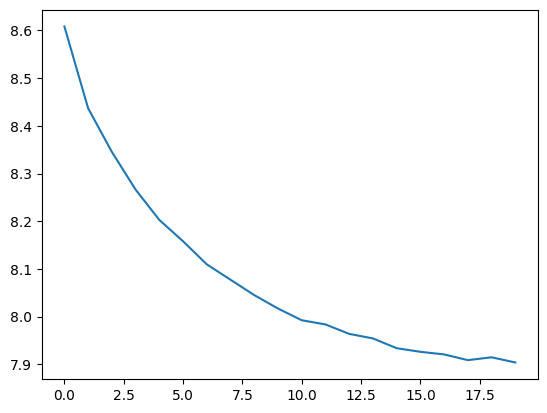

In [32]:
sns.lineplot(epoch_losses)

In [33]:
torch.save(model.state_dict(), 'weights.pth')

In [101]:
def generate_playlist(model, start_sequence, song_to_artist_genre_map, max_length=30, top_k=5):
    model.eval()
    track, artist, tags = start_sequence
    track, artist, tags = track.to(device), artist.to(device), tags.to(device)
    track = track.unsqueeze(0)  # Add batch dimension
    artist = artist.unsqueeze(0)
    tags = tags.unsqueeze(0)

    generated_sequence = []

    with torch.no_grad():
        for _ in range(max_length):
            output = model(track, artist, tags, torch.tensor([len(artist)]))
            output = output.squeeze()  # Remove unnecessary dimension
            probabilities = torch.softmax(output, dim=0)  # Get probability distribution
            top_k_probs, top_k_indices = torch.topk(probabilities, top_k)  # Get top k
            top_k_probs = top_k_probs.cpu().numpy()
            top_k_indices = top_k_indices.cpu().numpy()
            top_k_probs = top_k_probs / top_k_probs.sum()  # Normalize probabilities
            next_index = np.random.choice(top_k_indices, p=top_k_probs) + 1  # Sample next index

            generated_sequence.append(next_index)

            # Update the track input for the next time step
            next_input = torch.tensor([[next_index]], dtype=torch.long).to(device)
            track = torch.cat([track, next_input], dim=1)

            # Update artist and tags dynamically
            next_artist = torch.tensor([[song_to_artist_genre_map[next_index][0]]], dtype=torch.long).to(device)
            next_tag = torch.tensor([[song_to_artist_genre_map[next_index][1]]], dtype=torch.long).to(device)
            artist = torch.cat([artist, next_artist], dim=1)
            tags = torch.cat([tags, next_tag], dim=1)

    return generated_sequence



In [102]:
df

,date_listened,track_name,artist,album_name,uts,url,tags,session_id,song_id,artist_id,genre_id
0,2022-11-30 14:34:00,You Want It Darker,Leonard Cohen,You Want It Darker,1669818859,https://www.last.fm/music/Leonard+Cohen/_/You+...,singer-songwriter,0,5333,632,211
1,2022-11-30 16:02:00,You Want It Darker,Leonard Cohen,You Want It Darker,1669824136,https://www.last.fm/music/Leonard+Cohen/_/You+...,singer-songwriter,1,5333,632,211
2,2022-12-01 01:45:00,All My Friends (feat. Tinashe & Chance the Rap...,Snakehips,All My Friends (feat. Tinashe & Chance The Rap...,1669859126,https://www.last.fm/music/Snakehips/_/All+My+F...,electronic,2,302,943,103
3,2022-12-01 01:48:00,Green Onions,Booker T. & The M.G.'s,Green Onions,1669859298,https://www.last.fm/music/Booker+T.+&+The+M.G....,soul,2,1873,143,215
4,2022-12-01 01:50:00,715 - CR∑∑KS,Bon Iver,"22, a Million",1669859425,https://www.last.fm/music/Bon+Iver/_/715+-+CR%...,folk,2,148,142,115
...,...,...,...,...,...,...,...,...,...,...,...
18224,2024-08-12 05:06:00,Le Risque,King Gizzard & The Lizard Wizard,Flight b741,1723439181,https://www.last.fm/music/King+Gizzard+&+The+L...,Psychedelic Rock,2506,2663,595,37
18225,2024-08-12 05:08:00,Flight b741,King Gizzard & The Lizard Wizard,Flight b741,1723439339,https://www.last.fm/music/King+Gizzard+&+The+L...,Psychedelic Rock,2506,1584,595,37
18226,2024-08-12 05:12:00,Sad Pilot,King Gizzard & The Lizard Wizard,Flight b741,1723439578,https://www.last.fm/music/King+Gizzard+&+The+L...,Psychedelic Rock,2506,3931,595,37
18227,2024-08-12 05:17:00,Rats In The Sky,King Gizzard & The Lizard Wizard,Flight b741,1723439829,https://www.last.fm/music/King+Gizzard+&+The+L...,Psychedelic Rock,2506,3755,595,37


In [115]:
sample = df.sample(random_state=33333)[["track_name", "artist", "tags"]]
print(sample)
song_id = sample["track_name"].apply(lambda x: track_encoder.transform([x])[0]).values
artist_id = sample["artist"].apply(lambda x: artist_encoder.transform([x])[0]).values
genre_id = sample["tags"].apply(lambda x: genre_encoder.transform([x])[0]).values

inputs = [torch.tensor(x) for x in [song_id, artist_id, genre_id]]


         track_name  artist        tags
11025  Wave Therapy  Sampha  electronic


In [118]:
playlist = generate_playlist(model, inputs, song_to_artist_genre_map)
playlist

[4203,
 4203,
 3652,
 3777,
 2651,
 4203,
 4203,
 2651,
 3777,
 3652,
 1429,
 2651,
 4203,
 2651,
 3652,
 2651,
 4203,
 1429,
 1429,
 3652,
 4203,
 3777,
 4203,
 3652,
 3777,
 1429,
 3777,
 3777,
 3652,
 4203]

RNN model really favours the more recent listening, so I'll try LSTM

In [119]:
for i in playlist:
    print(df[df['song_id']==i])


           date_listened            track_name      artist  \
6137 2023-06-04 05:51:00  Something in My Soul  Diggs Duke   

                album_name         uts  \
6137  Offering for Anxious  1685857864   

                                                    url  tags  session_id  \
6137  https://www.last.fm/music/Diggs+Duke/_/Somethi...  jazz         831   

      song_id  artist_id  genre_id  
6137     4203        292       151  
           date_listened            track_name      artist  \
6137 2023-06-04 05:51:00  Something in My Soul  Diggs Duke   

                album_name         uts  \
6137  Offering for Anxious  1685857864   

                                                    url  tags  session_id  \
6137  https://www.last.fm/music/Diggs+Duke/_/Somethi...  jazz         831   

      song_id  artist_id  genre_id  
6137     4203        292       151  
            date_listened track_name    artist album_name         uts  \
17498 2024-07-26 04:31:00    Primary  The Cure   

In [82]:
df[df['track_name']=="Memories Can't Wait"]

,date_listened,track_name,artist,album_name,uts,url,tags,session_id,song_id,artist_id,genre_id
7581,2023-08-07 00:20:00,Memories Can't Wait,Talking Heads,Fear of Music,1691367606,https://www.last.fm/music/Talking+Heads/_/Memo...,new wave,1066,2981,996,170
7587,2023-08-07 00:42:00,Memories Can't Wait,Talking Heads,Fear of Music,1691368973,https://www.last.fm/music/Talking+Heads/_/Memo...,new wave,1066,2981,996,170
7612,2023-08-07 05:25:00,Memories Can't Wait,Talking Heads,Fear of Music,1691385946,https://www.last.fm/music/Talking+Heads/_/Memo...,new wave,1068,2981,996,170
7874,2023-08-11 13:32:00,Memories Can't Wait,Talking Heads,Fear of Music,1691760743,https://www.last.fm/music/Talking+Heads/_/Memo...,new wave,1098,2981,996,170
9896,2023-10-30 05:53:00,Memories Can't Wait,Talking Heads,Fear of Music,1698645201,https://www.last.fm/music/Talking+Heads/_/Memo...,new wave,1366,2981,996,170


In [92]:
track_encoder.inverse_transform([2980])

array(["Memories Can't Wait"], dtype=object)

In [95]:
df[df['song_id'] == 2981]

,date_listened,track_name,artist,album_name,uts,url,tags,session_id,song_id,artist_id,genre_id
7581,2023-08-07 00:20:00,Memories Can't Wait,Talking Heads,Fear of Music,1691367606,https://www.last.fm/music/Talking+Heads/_/Memo...,new wave,1066,2981,996,170
7587,2023-08-07 00:42:00,Memories Can't Wait,Talking Heads,Fear of Music,1691368973,https://www.last.fm/music/Talking+Heads/_/Memo...,new wave,1066,2981,996,170
7612,2023-08-07 05:25:00,Memories Can't Wait,Talking Heads,Fear of Music,1691385946,https://www.last.fm/music/Talking+Heads/_/Memo...,new wave,1068,2981,996,170
7874,2023-08-11 13:32:00,Memories Can't Wait,Talking Heads,Fear of Music,1691760743,https://www.last.fm/music/Talking+Heads/_/Memo...,new wave,1098,2981,996,170
9896,2023-10-30 05:53:00,Memories Can't Wait,Talking Heads,Fear of Music,1698645201,https://www.last.fm/music/Talking+Heads/_/Memo...,new wave,1366,2981,996,170


In [96]:
song_to_artist_genre_map[2981]

(996, 170)